In [8]:
#first lets grab some genes of interest from uniprot.
#I'll just be pulling these with a GO term from the human proteome
#we need the BGEE crossref for some of the analysis we do at the end
#You could use any list of genes from any organism in uniprot as a starting point
#I've capped the number of proteins at 50 for the sake of brevity in these calculations
#but feel free to change this...

import urllib.parse
import urllib.request

def unirequest_tab(GOterm):
    #this is shamelessly lifted from the uniprot programmatic access page
    url = 'https://www.uniprot.org/uniprot/'
    params = {
    'columns': 'id,entry name,reviewed,protein names,genes,organism,length,database(Bgee)',
    'format': 'tab',
    'query' : 'taxonomy:"Homo sapiens (Human) [9606]" goa:( {} )'.format(GOterm),
    'limit' : 50
    }
    
    data = urllib.parse.urlencode(params)
    
    data = data.encode('utf-8')
    
    req = urllib.request.Request(url, data)
    
    with urllib.request.urlopen(req) as f:
       response = f.read()
    r = response.decode('utf-8')
    return r

#here we pull in our proteins of interest for each biological process
TOR = unirequest_tab("TOR signaling [31929]")
OLF = unirequest_tab("olfactory behavior [42048]")


Entry	Entry name	Status	Protein names	Gene names	Organism	Length	Cross-reference (Bgee)
Q13541	4EBP1_HUMAN	reviewed	Eukaryotic translation initiation factor 4E-binding protein 1 (4E-BP1) (eIF4E-binding protein 1) (Phosphorylated heat- and acid-stable protein regulated by insulin 1) (PHAS-I)	EIF4EBP1	Homo sapiens (Human)	118	ENSG00000187840;
P31749	AKT1_HUMAN	reviewed	RAC-alpha serine/threonine-protein kinase (EC 2.7.11.1) (Protein kinase B) (PKB) (Protein kinase B alpha) (PKB alpha) (Proto-oncogene c-Akt) (RAC-PK-alpha)	AKT1 PKB RAC	Homo sapiens (Human)	480	ENSG00000142208;
Q13542	4EBP2_HUMAN	reviewed	Eukaryotic translation initiation factor 4E-binding protein 2 (4E-BP2) (eIF4E-binding protein 2)	EIF4EBP2	Homo sapiens (Human)	120	ENSG00000148730;
Q2KHT3	CL16A_HUMAN	reviewed	Protein CLEC16A (C-type lectin domain family 16 member A)	CLEC16A KIAA0350	Homo sapiens (Human)	1053	ENSG00000038532;
Q3V6T2	GRDN_HUMAN	reviewed	Girdin (Akt phosphorylation enhancer) (APE) (Coiled-coil domain-contai

In [4]:
import urllib.parse
import urllib.request

url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'ACC+ID',
'to': 'ENSEMBL_ID',
'format': 'tab',
'query': 'P40925 P40926 O43175 Q9UM73 P97793'
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
print(response.decode('utf-8'))

From	To
P40925	ENSG00000014641
P40926	ENSG00000146701
O43175	ENSG00000092621
Q9UM73	ENSG00000171094
P97793	ENSMUSG00000055471



In [ ]:
import pandas as pd
import numpy as np
from io import StringIO

#lets load our queries into some dataframes
TORqueries = pd.read_table(StringIO(TOR))
TORqueries['pathway'] = 'MTOR'

#this set of genes unrelated to MTOR will serve as an outgroup to our MTOR related genes
#their evolutionary and expression profiles should not correlate well with MTOR
#let's add some genes involved in olfactory receptor processes
OLFqueries = pd.read_table(StringIO(OLF))
OLFqueries['pathway']='Olfactory'

#here's our total starting dataset for this tutorial
queries = pd.concat([TORqueries,OLFqueries])

#let's use the names each protein has in humans throughout our analysis.
#This should allow us to compare the results of all our different types of analysis
#If the protein doesn't have a name we'll just use the human uniprot identifier

names= { query.Entry:query['Entry name'].split('_')[0]+ ' '+query.pathway for index,query in queries[['Entry','Entry name','pathway']].iterrows() if query['Entry name'] is not np.nan }

In [3]:
#let's take a look at our starting data
queries.head()

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Cross-reference (Bgee),pathway
0,Q2KHT3,CL16A_HUMAN,reviewed,Protein CLEC16A (C-type lectin domain family 1...,CLEC16A KIAA0350,Homo sapiens (Human),1053,ENSG00000038532;,MTOR
1,Q9BPZ7,SIN1_HUMAN,reviewed,Target of rapamycin complex 2 subunit MAPKAP1 ...,MAPKAP1 MIP1 SIN1,Homo sapiens (Human),522,ENSG00000119487;,MTOR
2,Q8TAI7,REBL1_HUMAN,reviewed,GTPase RhebL1 (Ras homolog enriched in brain l...,RHEBL1,Homo sapiens (Human),183,ENSG00000167550;,MTOR
3,Q96A49,SYAP1_HUMAN,reviewed,Synapse-associated protein 1 (BSD domain-conta...,SYAP1 PRO3113,Homo sapiens (Human),352,ENSG00000169895;,MTOR
4,Q6MZQ0,PRR5L_HUMAN,reviewed,Proline-rich protein 5-like (Protein observed ...,PRR5L PROTOR2,Homo sapiens (Human),368,ENSG00000135362;,MTOR


In [4]:
from omadb import Client
c = Client()
omadata = {}
#retrieve oma entries
for query in list(queries['Entry']) :    
    try:
        omadata[query] = c.entries.__getitem__(query) 
    except:
        print('err ' +query)

err I3L2I3
err I3L2E7
err D6R9S6
err Q6DKI0
err B7Z3S8
err Q8N6M7
err P0C623
err A6NMZ5
err Q8NHA8
err P0DMU2
err P0C629
err Q8NGN7


In [5]:
#lets get all orthologoues of entries from human
#in all of the species they're found in
orthologs = {}
for query in omadata:
    orthologs[query] = c.entries.orthologs(omadata[query]['omaid'])

In [6]:
#we can create profiles w just orthology data
#lets use species codes to as columns
profiles = {}
for query in orthologs:
    profiles[query] = {}
    profiles[query]['name'] = names[query]
    for ortho in orthologs[query]:
        spec = ortho['omaid'][0:5]
        if spec not in profiles[query]:
            profiles[query][spec] = 1
        else:
            profiles[query][spec]+=1

#the columns for our matrix are the union of all the species represented across all orthologs
#we need to add in 0s where the orthologs are absent
columns = set([ spec  for query in profiles for spec in profiles[query] ])
for query in profiles:
    profiles[query].update( { spec : 0 for spec in columns if spec not in profiles[query] } )

#we can create a dataframe with this dictionary
orthosdf = pd.DataFrame.from_dict( profiles , orient = 'index')
orthosdf.index = orthosdf.name
orthosdf = orthosdf.drop('name', axis = 1)


In [7]:
orthosdf.head()

,MONBE,SALR5,BRAFL,EPTBU,LEPOC,ANATE,SERDU,CYNSE,SCOMX,GASAC,...,HAES1,SYMTH,HELPI,MYCAS,LACRG,THAPS,PSEPJ,GIBM7,YEAST,MAGP6
name,,,,,,,,,,,,,,,,,,,,,
A0A024QZM3 MTOR,0,0,0,1,1,1,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0
A0A0A0MR05 MTOR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR5H1 Olfactory,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B4DJ80 MTOR,0,0,1,0,1,1,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
B4E2R3 MTOR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


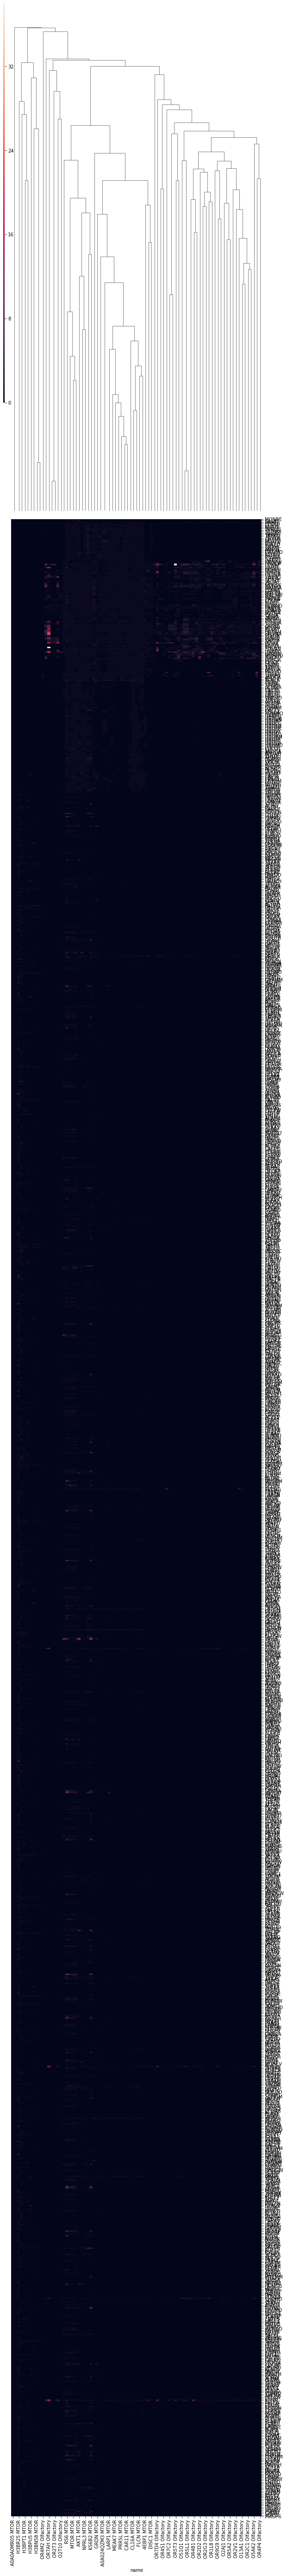

In [10]:
#now that we have our binary vectors of orthologs
#let's import seaborn to visualize the clustering of these functional modules
import seaborn as sns
from matplotlib import pyplot as plt

#and here are some metrics used to compare the vectors to establish a distance kernel

metrics = [ 'euclidean', 'hamming', 'jaccard' ]

#as well as different hierarchical clustering methods

methods = [ 'average' , 'weighted' , 'centroid']

#lets visualize the clustered profile matrix

sns.clustermap( orthosdf.T , metric= metrics[2] , method=methods[1] , col_cluster=True, row_cluster= False, yticklabels = orthosdf.columns , figsize = (10, 100))

#feel free to play around with the different types of metrics

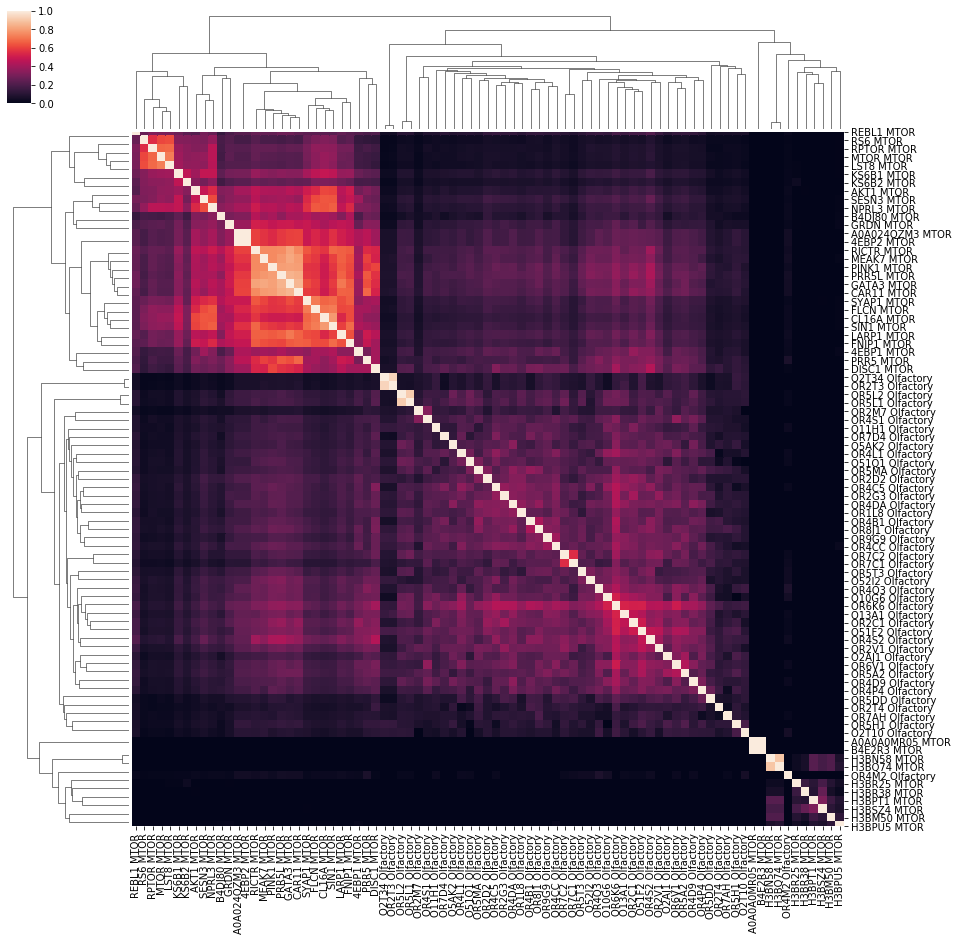

In [9]:
#the last view wasn't very interpretable even though it allows us to see all the 
#different genomes these orthologs are in

#here we directly establish the distance matrix between all profiles before visualising
#It's a more 'module-centric' view were we discard the presence absence information
#and only visulaize the relationship between the sets 

from scipy.spatial.distance import cdist

#let's generate a distance kernel with a distance metric of our choice
distmat = cdist(orthosdf.to_numpy(), orthosdf.to_numpy() , metric = metrics[2])
#and visualize the result
sns.clustermap( 1-distmat , metric= metrics[0] , method=methods[1] , col_cluster=True, row_cluster= True, yticklabels = orthosdf.index , xticklabels = orthosdf.index , figsize = (15, 15))
#much nicer
#MTOR is separate from the olfactory genes!

In [14]:
#now with pyham over the all taxonomic levels with evolutionary events
#extra spicy

#lets try to load HOG data into HAMs and analyze the evolutionary trajectory of each family
import pyham 
database_to_query = 'oma'
Hams = {}
#Pyham can directly access the data in OMA for each of our query genes. we just need to give it
#the ID and it does the rest...usually
for query in omadata:    
    try:
        Hams[query] = pyham.Ham(query_database=omadata[query]['omaid'], use_data_from=database_to_query) 
    except:
        print('err ' + query)


err Q8TAI7
err P62753
err Q9BVC4
err P42345
err P58005
err Q8N122
err Q12980
err Q9UBS0
err P23443
err P31749
err H3BR25
err H3BR38
err A0A0A0MR05
err H3BSZ4
err H3BQ74
err H3BPT1
err B4E2R3
err H3BN58
err H3BM50


In [11]:
#we can look at the evolutionary events that happened to generate the extant distribution of sequences
#for any of the families we were able to retrieve.
hogs = Hams['P17787'].get_dict_top_level_hogs() 
prof = Hams['P17787'].create_tree_profile(outfile="jambon.html")

#we can output an html file with an interactive visualization of the
#HOG's enhanced phylogeny
from IPython.core.display import display, HTML
with open( 'jambon.html') as hamin:
    display(HTML(hamin.read()))

NameError: name 'Hams' is not defined

In [ ]:
#lets look at how many taxonomic levels and species are in our input matrix
taxaIndex = set([ taxon.name for H in Hams for taxon in Hams[H].taxonomy.tree.traverse() ]) 
species = set( [ taxon.name for H in Hams for taxon in Hams[H].taxonomy.tree.get_leaves()])
print('taxa:'+str(len(taxaIndex)))
print('species:'+str(len(species)))

In [12]:
profiles = {}
import numpy as np
#we can construct a matrix representing the evolutionary events for each HOG much like 
#we did using the orthologues in the first step
for query in Hams:
    hogs = Hams[query].get_list_top_level_hogs()
    for hog in hogs:    
        profiles[hog.hog_id] = {}
        tp = Hams[query].create_tree_profile(hog = hog).treemap
        
        #here we traverse each annotated tree and record the events in a dictionary
        
        #n is the node in the tree
        #lets check for losses
        losses = { n.name+'_loss': n.lost  for n in tp.traverse() if n.lost  }
        losses.update( { t+'_loss': 0 for t in taxaIndex if t+'_loss' not in losses} )
        
        profiles[hog.hog_id].update(losses)
        
        #now duplication events
        dupl = { n.name+'_dupl': n.dupl for n in tp.traverse() if n.dupl   }
        dupl.update( {t+'_dupl': 0 for t in taxaIndex if t+'_dupl' not in dupl} )
        
        profiles[hog.hog_id].update(dupl)
        
        #and finally infered copy number
        copies = { n.name+'_copies': n.nbr_genes for n in tp.traverse() if n.nbr_genes > 0  }
        nocopies = {t+'_copies': 0 for t in taxaIndex if t+'_copies' not in copies}
        copies.update( nocopies )
        
        profiles[hog.hog_id].update(copies)
        
        #finally let's add the human name information to indicate what this HOG corresponds to
        profiles[hog.hog_id]['name']=  names[query]
        

profile_df = pd.DataFrame.from_dict( profiles , orient = 'index')
profile_df.index = profile_df.index +' : ' + profile_df.name
profile_df = profile_df.drop('name' , axis = 1)


NameError: name 'Hams' is not defined

In [13]:
#again let's take a look at our input data
#this time it includes 3 categories and all taxonomic levels
profile_df.head()

NameError: name 'profile_df' is not defined

In [ ]:
#here we can filter the nodes of the species tree we'd like to consider in our analysis
#the intersection of the set of nodes in the subtree and the nodes found in our HOGs
#should reduced the columns in the matrix so we have just a coevolutionary signal from
#a part of the tree of life

selected_taxa = species
#get the species

events = [ '_copies'  , '_dupl' , '_loss']
#we have 3 possible types of events for each node in the species tree
cols = [ t+e for e in events for t in taxaIndex ]

#slice the df to get matrices
sub_df = profile_df.loc[:,cols]
sub_df = sub_df.loc[:, (sub_df != 0).any(axis=0)]
print(sub_df)


In [ ]:

sns.clustermap( sub_df.T , metric= metrics[2] , method=methods[1] , col_cluster=True, row_cluster= False, yticklabels = sub_df.columns , figsize = (10, 35))

In [ ]:
#let's look at the module centric view again
#Its 
distmat = cdist(sub_df.to_numpy(), sub_df.to_numpy() , metric = metrics[2])
sns.clustermap(1- distmat , metric= metrics[0] , method=methods[0] , col_cluster=True, row_cluster= True, yticklabels = sub_df.index , xticklabels = sub_df.index , figsize = (15, 15))

In [12]:
#let's use independent analysis to comfirm 
#fetching expression data from bgee
#If genes are coexpressed across different tissues in similar patterns 
#they are most likely interacting
#This is more particular to each organism and unrelated to their evolutionary history

#we need the BGee cross reference for human
qlist = { query.Entry:query['Cross-reference (Bgee)'].replace(';','') for index,query in queries[['Entry','Cross-reference (Bgee)']].iterrows() if query['Cross-reference (Bgee)'] is not np.nan }
qlists = {'HUMAN': qlist }

# now using some cross references to other organisms
xrefs = {}
#we're going to grab the ensemble IDs for the TOR pathway orthologues from a few species
#These are also present in the Bgee dataset
#Bgee species are listed here https://bgee.org
#species information for OMA is available at https://omabrowser.org/All/oma-species.txt
#Ive selected some interesting species...
#let's grab the xrefs for orthologues in these species
species = [ 'DROME','CAEEL' , 'DANRE' , 'MOUSE' , 'PIGXX']
#... my cat would never forgive me if I didn't include them in the analysis
species +=['FELCA']

#ok let's get the get the uniprot xrefs for each of the sequences
allnames = {}
for q in orthologs:
    for o in orthologs[q]:
        for spec in species:
            if spec not in xrefs:
                xrefs[spec] = {}
            if  o['omaid'][0:5] == spec:
                xrefs[spec][o['omaid'] ] = c.entries.xrefs(o['omaid'])
                if 'UniProtKB/TrEMBL' in xrefs[spec][o['omaid'] ]:
                    names[ xrefs[spec][o['omaid']]['UniProtKB/TrEMBL'][0]] = names[q]
allnames.update(names)


In [13]:
#if we have the 'Ensembl Gene' and 'UniProtKB/TrEMBL' for a gene we can add the genes to a list
#like we did for human. We don't care about version numbers for Ensemble so we'll remove them

import urllib.parse
import urllib.request
def unirequest(ID):
    #this is shamelessly lifted from the uniprot programmatic access page
    url = 'https://www.uniprot.org/uploadlists/'
    params = {
    'from': 'ID',
    'to': 'ENSEMBLGENOME_ID',
    'format': 'tab',
    'query': ID
    }
    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
       response = f.read()
    r = response.decode('utf-8')
    return {r.split()[2]:r.split()[3]}


for spec in species:
    
    #ok...lets try to map everything to ensembl gene IDs
    qlist = {}
    for entry in xrefs[spec]:
        if 'Ensembl Gene' in xrefs[spec][entry]  and 'UniProtKB/TrEMBL' in xrefs[spec][entry]:
            try:
                qlist.update({xrefs[spec][entry]['UniProtKB/TrEMBL'][0] : xrefs[spec][entry]['Ensembl Gene'][0].split('.')[0] })
            except IndexError:
                pass
        elif 'UniProtKB/TrEMBL' in xrefs[spec][entry]:
            try:
                #if we don't have then ensemble ID in OMA
                #we can still try and pull it from uniprot
                qlist.update(unirequest(xrefs[spec][entry]['UniProtKB/TrEMBL'][0]))
            except TypeError:
                pass
            except IndexError:
                pass
        
    qlists.update({spec:qlist})


In [14]:
#here we can pull the information for tissue specific expression for each of our genes using
#a sparql query for using lists of ensemble IDs on BGEE

#Once we retrieve this data we can verify if the clustering of expression patterns recapitulates the
#coevolutionary signal.

from SPARQLWrapper import SPARQLWrapper , CSV
from io import StringIO

endpt = "http://biosoda.expasy.org:8080/rdf4j-server/repositories/bgeelight"
sparql = SPARQLWrapper(endpt)

#here's the template sparql query we're going to be using
#we can add our gene IDs for each species

query = '''
PREFIX orth: <http://purl.org/net/orth#>
PREFIX genex: <http://purl.org/genex#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX lscr: <http://purl.org/lscr#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT distinct ?anat ?anatName ?geneEns{{
    values ?geneEns {{   {0}   }}
	?gene genex:isExpressedIn ?anat .
    ?gene lscr:xrefEnsemblGene ?geneEns.
	?gene rdfs:label ?geneName .
	?anat rdfs:label ?anatName .
}} 
'''

dfs = []
for species in qlists:
    #for each species in our queries
    pre = '<http://rdf.ebi.ac.uk/resource/ensembl/'
    suf = '>'
    #make a list of gene IDs
    ensemblelist = ''.join( [ pre + qlists[species][uniID]  + suf + ' ' for uniID in qlists[species] ] )
    
    #get the Bgee data
    sparql.setQuery(query.format(ensemblelist))
    sparql.setReturnFormat(CSV)
    results = sparql.query().convert()
    #and make a dataframe for our returned results
    sub = pd.DataFrame.from_csv(StringIO(results.decode()) )
    #let's add which species the data came from to our dataframe columns
    sub['species'] = species
    sub['geneEns'] = sub['geneEns'].map(lambda x : x.split('/')[-1])
    
    #lets add the uniprot cannonical IDs into our dataframe as well
    sub['canonicalid'] = sub['geneEns'].map(dict(zip( qlists[species].values(), qlists[species].keys() )))
    #and use these uniprot IDs to map back to our original human derived gene names 
    #to keep everything consistent
    sub['names'] =  sub['canonicalid'].map(names)
    dfs.append(sub)

    
#lets put everything into one big dataframe so we can play around with this data
#we're going to cluster it in a similar way to what we did with
#the OMA data

#yay! we have our data. Let's see if we can find some clusters of coexpressed genes
expressionDF = pd.concat(dfs)


/home/cactuskid/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


HUMAN
                                                                 anat  \
anatName                                                                
muscle of leg           http://purl.obolibrary.org/obo/UBERON_0001383   
medial globus pallidus  http://purl.obolibrary.org/obo/UBERON_0002477   
saphenous vein          http://purl.obolibrary.org/obo/UBERON_0007318   
body of tongue          http://purl.obolibrary.org/obo/UBERON_0011876   
uterus                  http://purl.obolibrary.org/obo/UBERON_0000995   

                                geneEns species canonicalid            names  
anatName                                                                      
muscle of leg           ENSG00000171496   HUMAN      Q8NGR8  OR1L8 Olfactory  
medial globus pallidus  ENSG00000140950   HUMAN      Q6P9B6       MEAK7 MTOR  
saphenous vein          ENSG00000108443   HUMAN      P23443       KS6B1 MTOR  
body of tongue          ENSG00000148730   HUMAN  A0A024QZM3  A0A024QZM3 MTOR  
uterus  

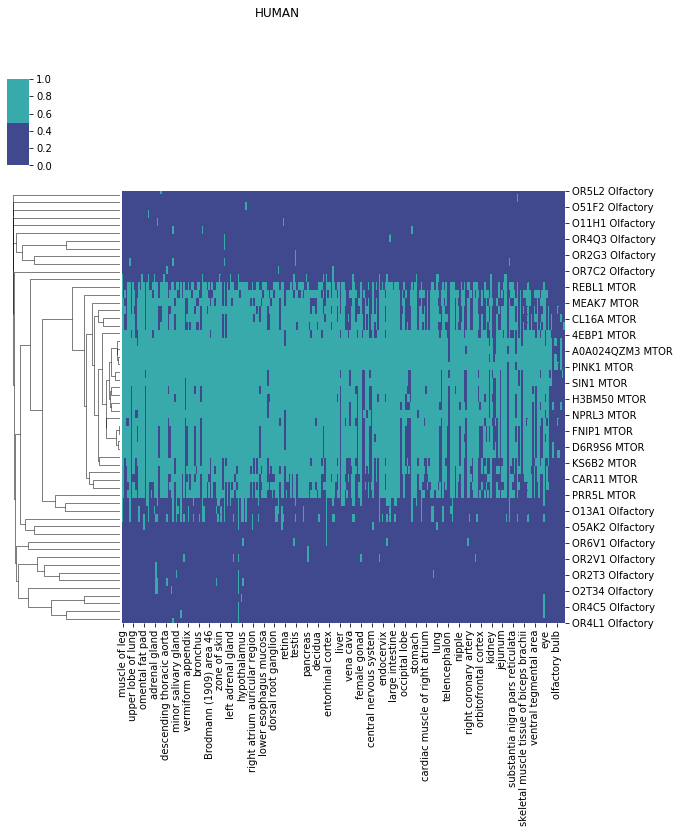

/home/cactuskid/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


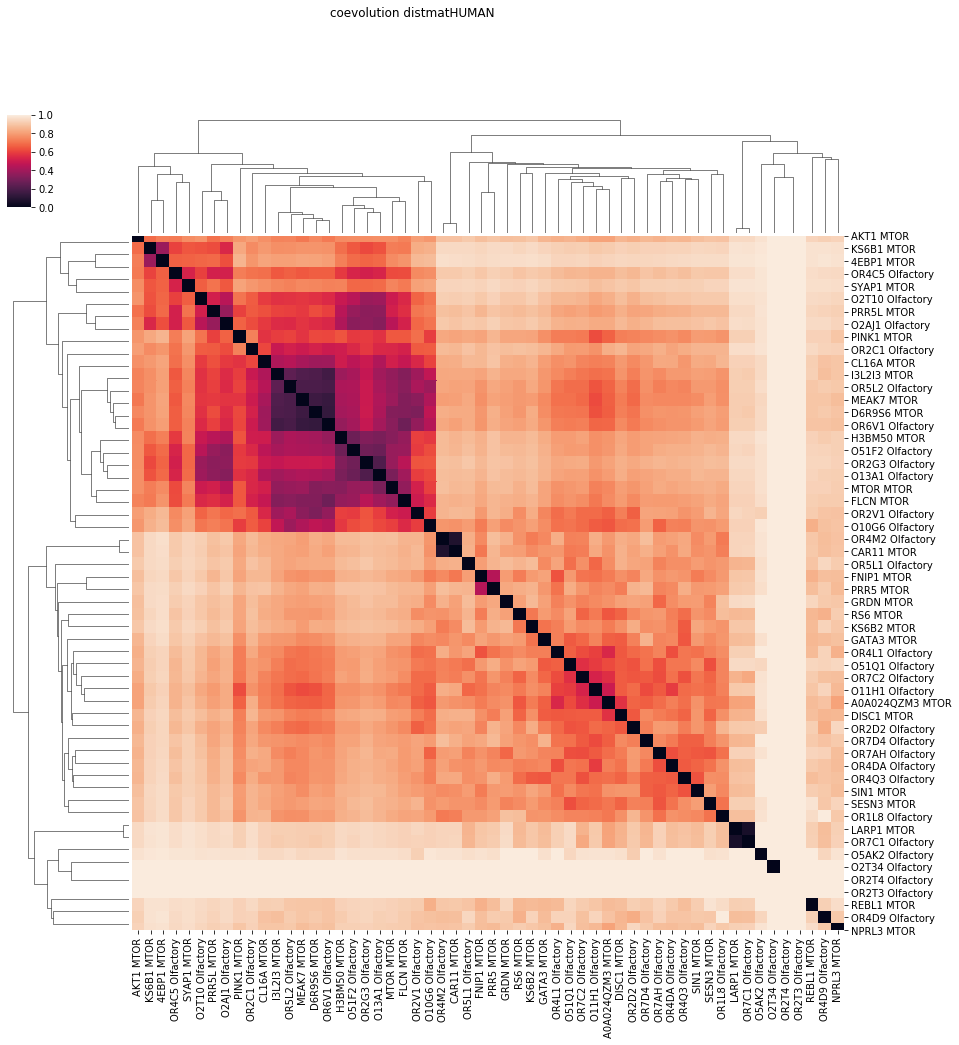

/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


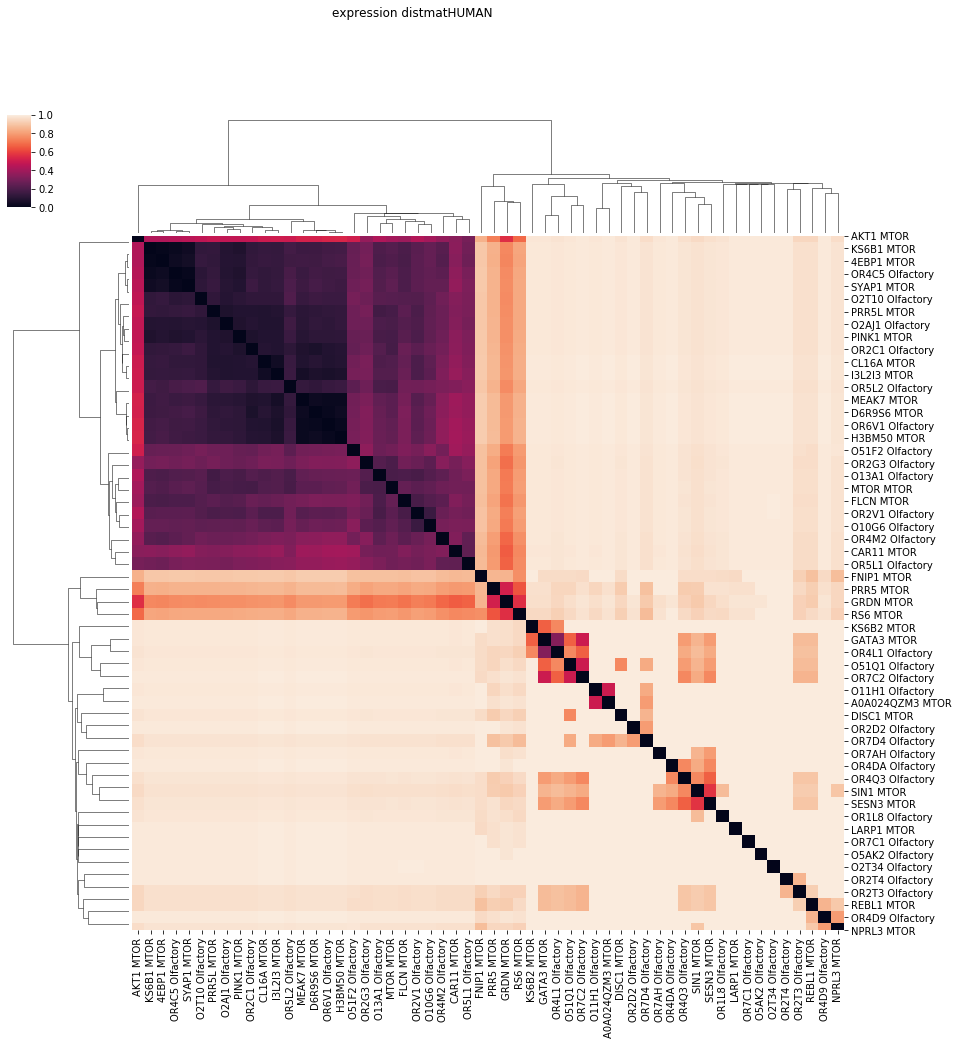

 do our matrices match from one approach to the other? 
Pearson:(0.10177980074741944, 1.1150174322154803e-08)
DROME
                                                                         anat  \
anatName                                                                        
brain                           http://purl.obolibrary.org/obo/UBERON_0000955   
secondary oocyte                    http://purl.obolibrary.org/obo/CL_0000655   
eye disc (Drosophila)            http://purl.obolibrary.org/obo/FBbt_00001768   
head capsule                    http://purl.obolibrary.org/obo/UBERON_0003153   
visual primordium (Drosophila)   http://purl.obolibrary.org/obo/FBbt_00001059   

                                    geneEns species canonicalid  \
anatName                                                          
brain                           FBgn0264691   DROME      B4F5L6   
secondary oocyte                FBgn0036397   DROME      B6IDY8   
eye disc (Drosophila)           FBgn0264691   DR

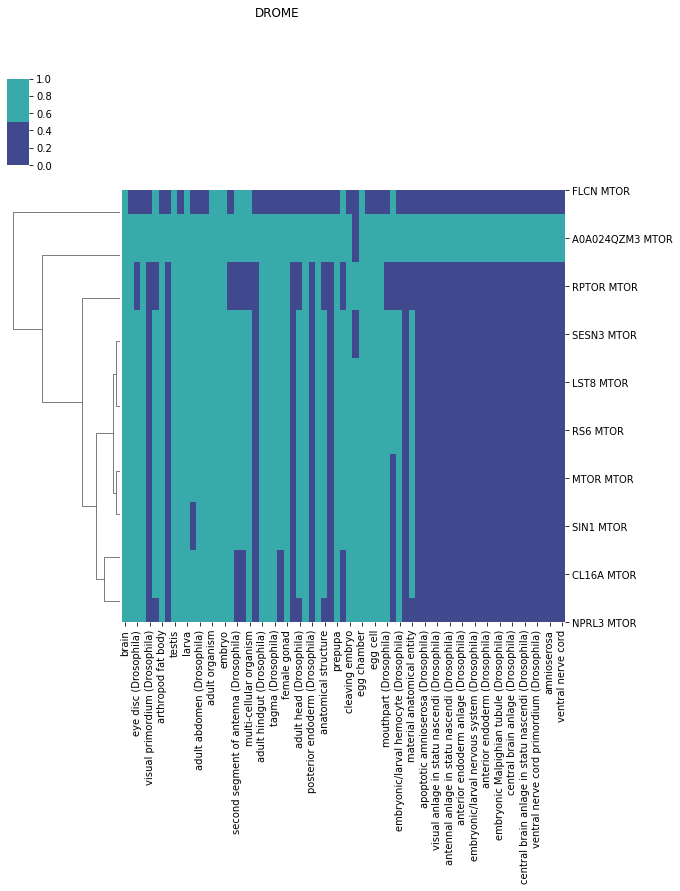

/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


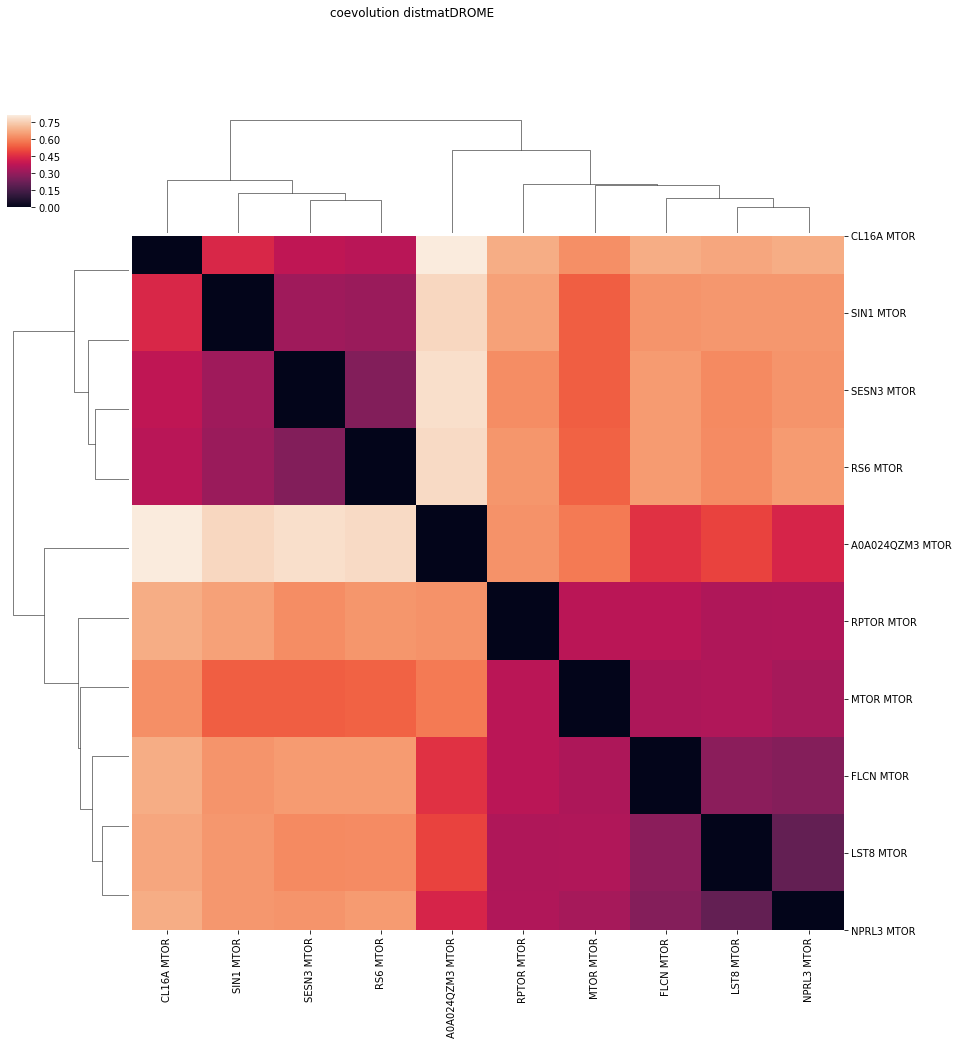

/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


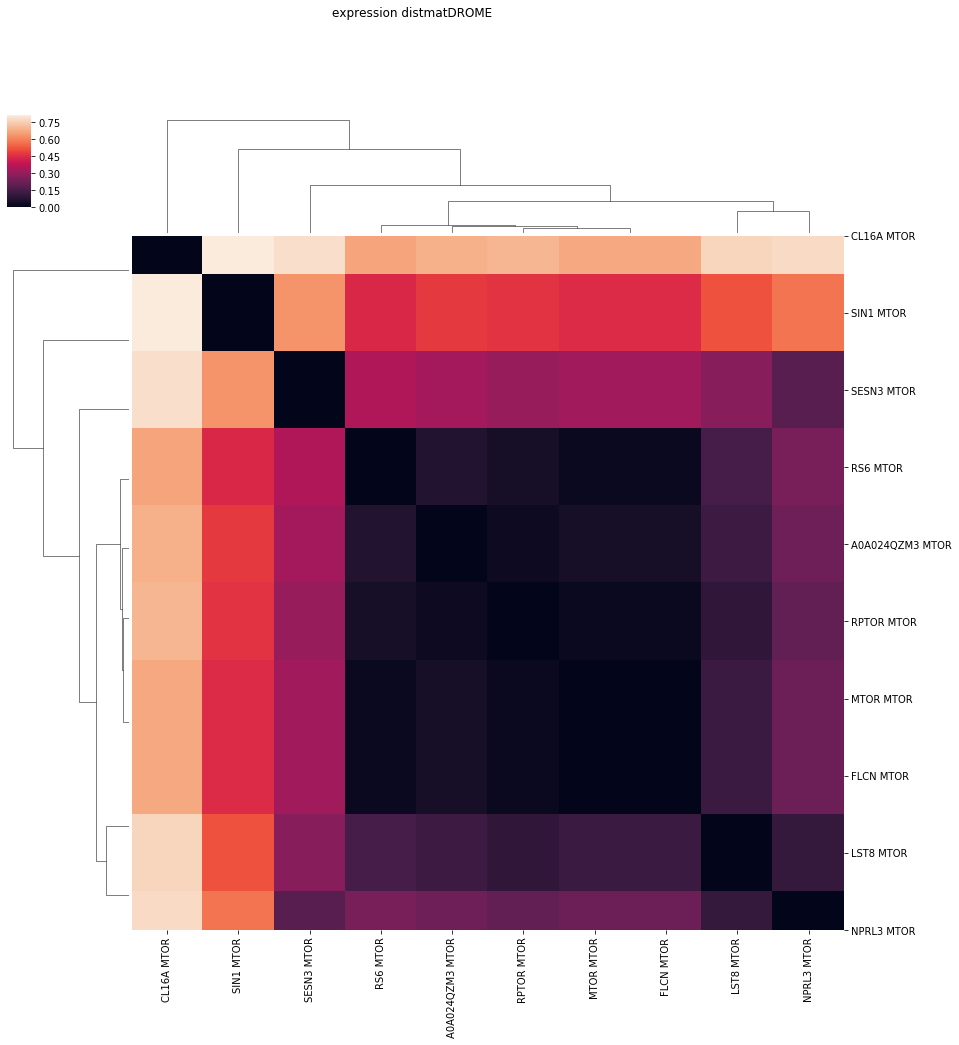

 do our matrices match from one approach to the other? 
Pearson:(0.19482526212356047, 0.05208697958171316)
CAEEL
                                                                             anat  \
anatName                                                                            
pharyngeal muscle cell (C elegans)    http://purl.obolibrary.org/obo/WBbt_0005451   
adult organism                      http://purl.obolibrary.org/obo/UBERON_0007023   
adult organism                      http://purl.obolibrary.org/obo/UBERON_0007023   
pharyngeal muscle cell (C elegans)    http://purl.obolibrary.org/obo/WBbt_0005451   
germ line (C elegans)                 http://purl.obolibrary.org/obo/WBbt_0005784   

                                           geneEns species canonicalid  \
anatName                                                                 
pharyngeal muscle cell (C elegans)  WBGene00004475   CAEEL      Q9NEN6   
adult organism                      WBGene00004979   CAEEL      O4451

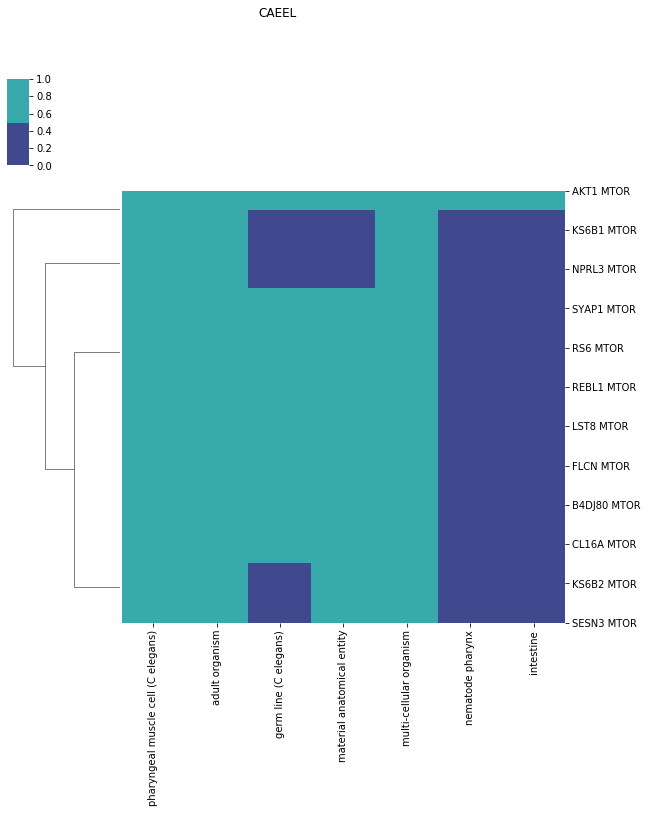

/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


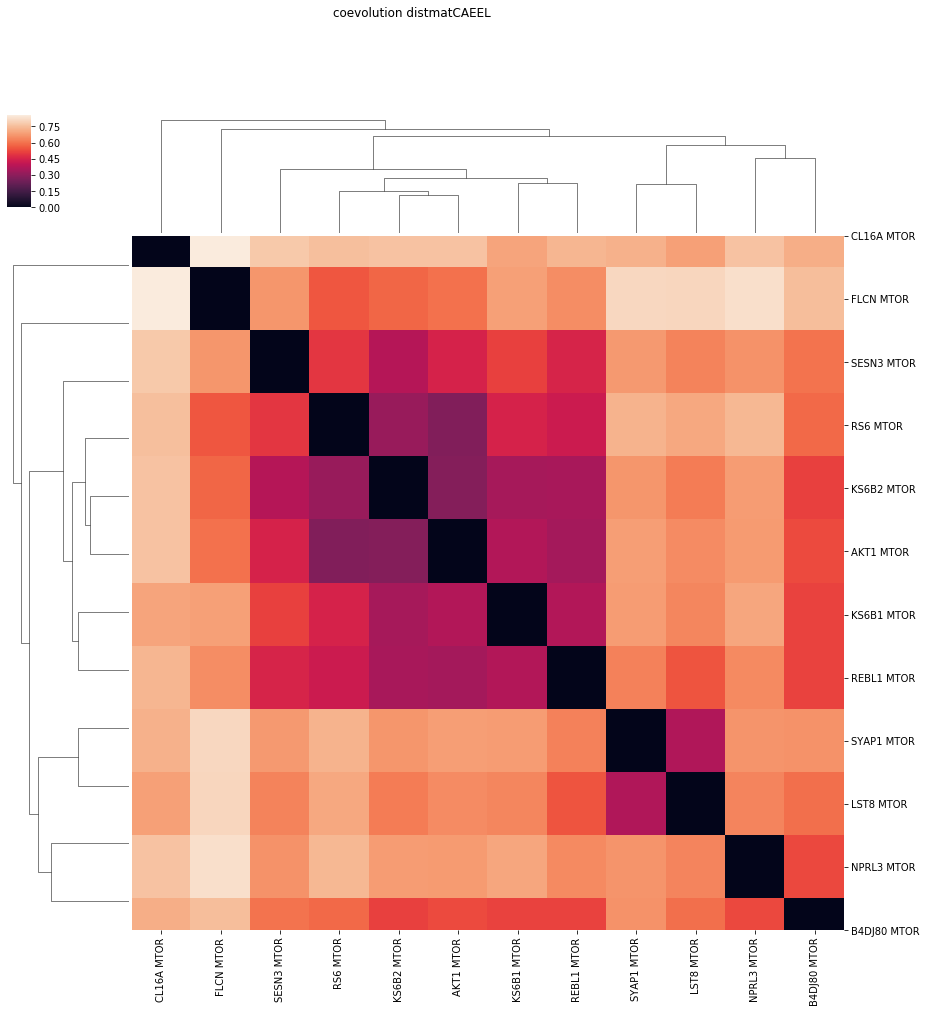

/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


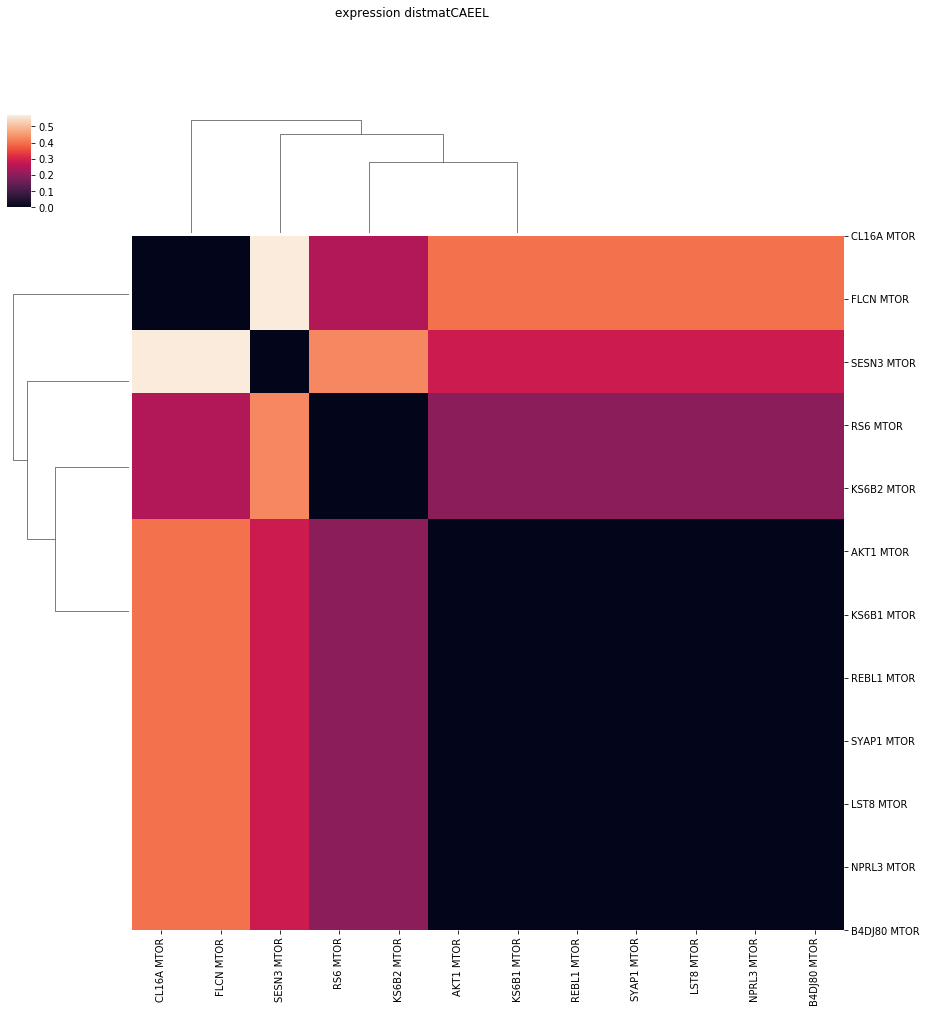

 do our matrices match from one approach to the other? 
Pearson:(0.33598688991258646, 3.837700644431489e-05)
DANRE
                                                          anat  \
anatName                                                         
larva            http://purl.obolibrary.org/obo/UBERON_0002548   
somite           http://purl.obolibrary.org/obo/UBERON_0002329   
cleaving embryo  http://purl.obolibrary.org/obo/UBERON_0007010   
brain            http://purl.obolibrary.org/obo/UBERON_0000955   
retina           http://purl.obolibrary.org/obo/UBERON_0000966   

                            geneEns species canonicalid       names  
anatName                                                             
larva            ENSDARG00000062385   DANRE      E9QIZ9   FLCN MTOR  
somite           ENSDARG00000053196   DANRE      B0UX67   MTOR MTOR  
cleaving embryo  ENSDARG00000003167   DANRE  A0A0R4IPN3   LST8 MTOR  
brain            ENSDARG00000062951   DANRE      Q1LWV7  MEAK7 MTOR  
re

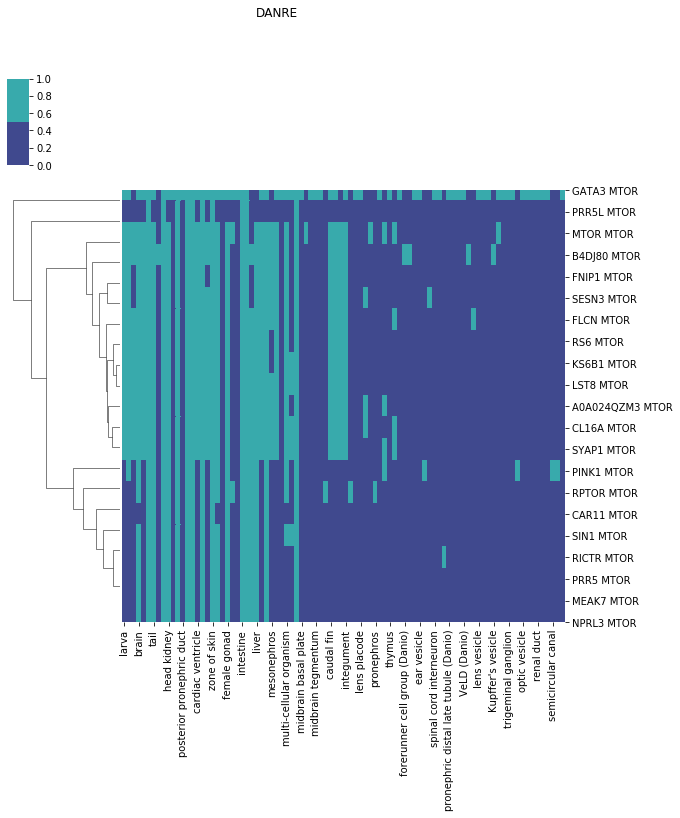

/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


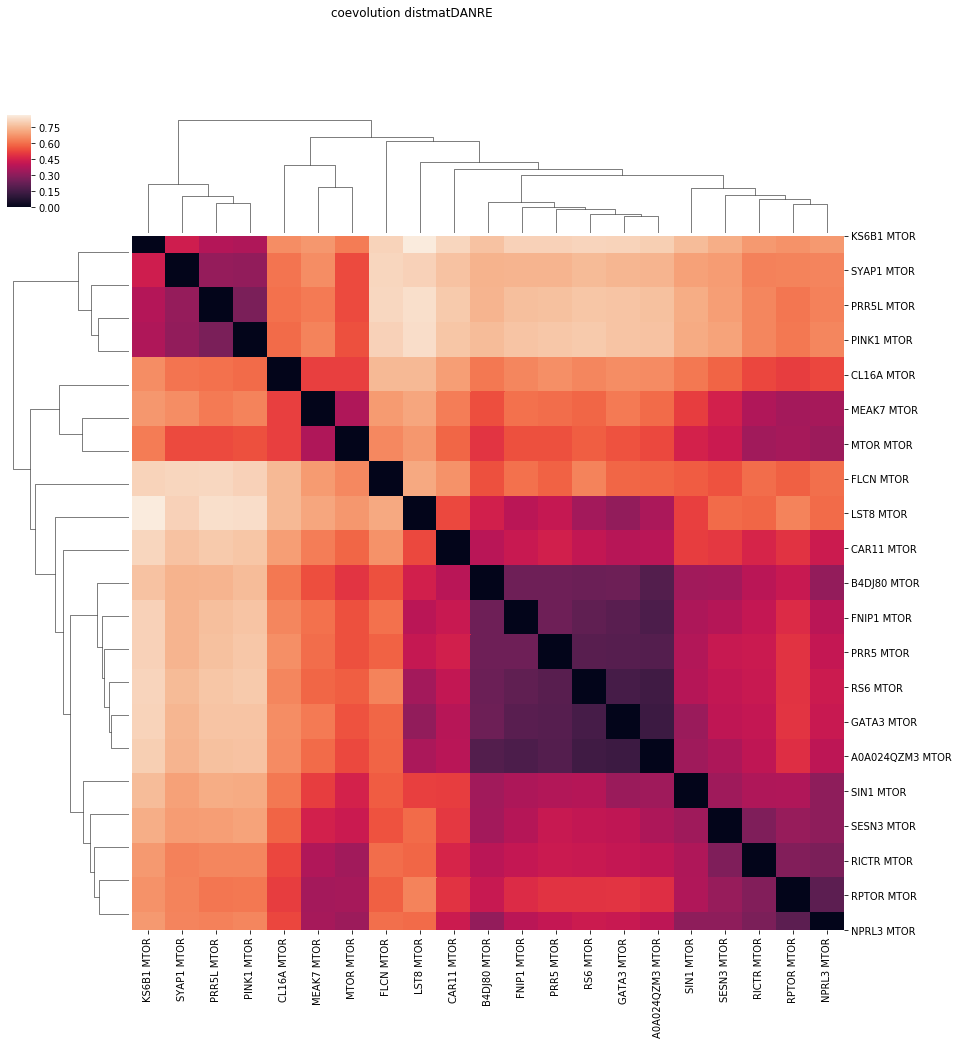

/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


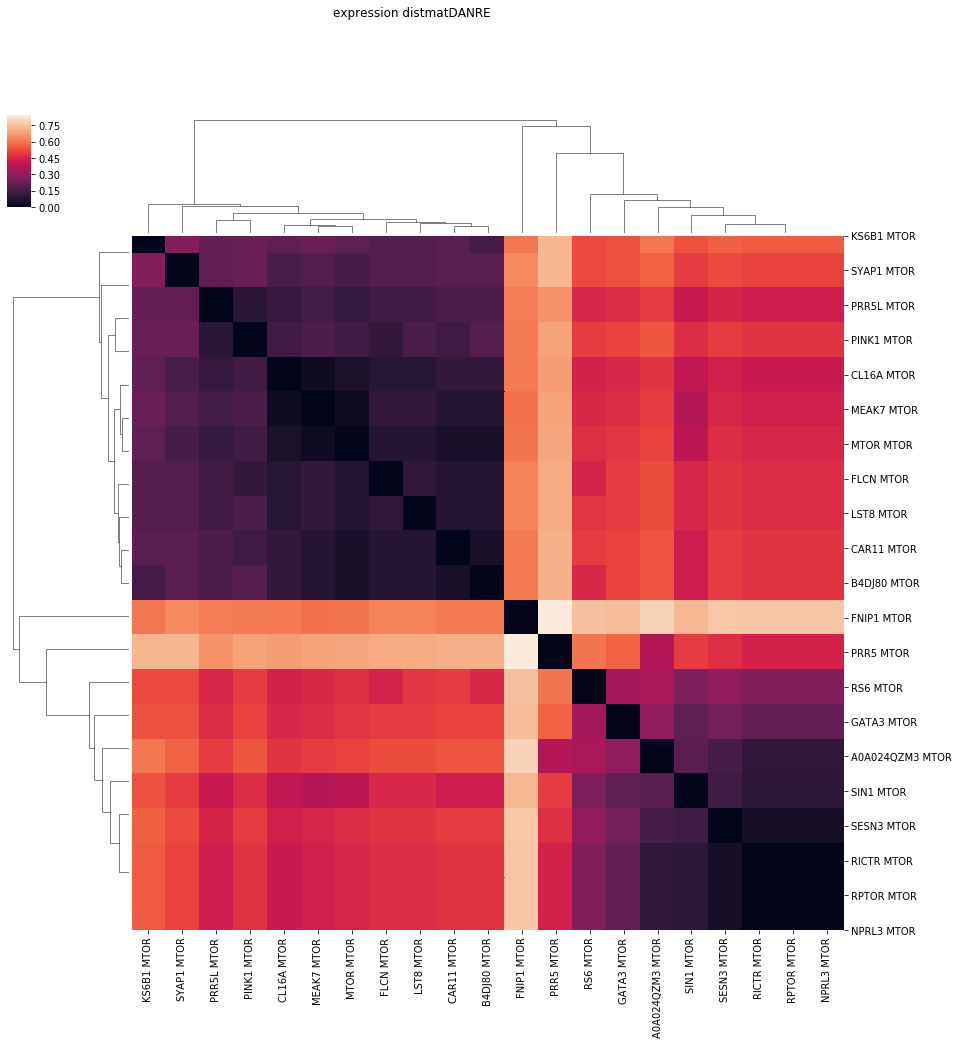

 do our matrices match from one approach to the other? 
Pearson:(0.24065004983993038, 3.142998805742788e-07)
MOUSE
                                                            anat  \
anatName                                                           
manus              http://purl.obolibrary.org/obo/UBERON_0002398   
bone marrow        http://purl.obolibrary.org/obo/UBERON_0002371   
cardiac atrium     http://purl.obolibrary.org/obo/UBERON_0002081   
muscle tissue      http://purl.obolibrary.org/obo/UBERON_0002385   
indifferent gonad  http://purl.obolibrary.org/obo/UBERON_0009117   

                              geneEns species canonicalid            names  
anatName                                                                    
manus              ENSMUSG00000020091   MOUSE      P70445  A0A024QZM3 MTOR  
bone marrow        ENSMUSG00000020091   MOUSE      P70445  A0A024QZM3 MTOR  
cardiac atrium     ENSMUSG00000028991   MOUSE      Q9JLN9        MTOR MTOR  
muscle tissue      ENSM

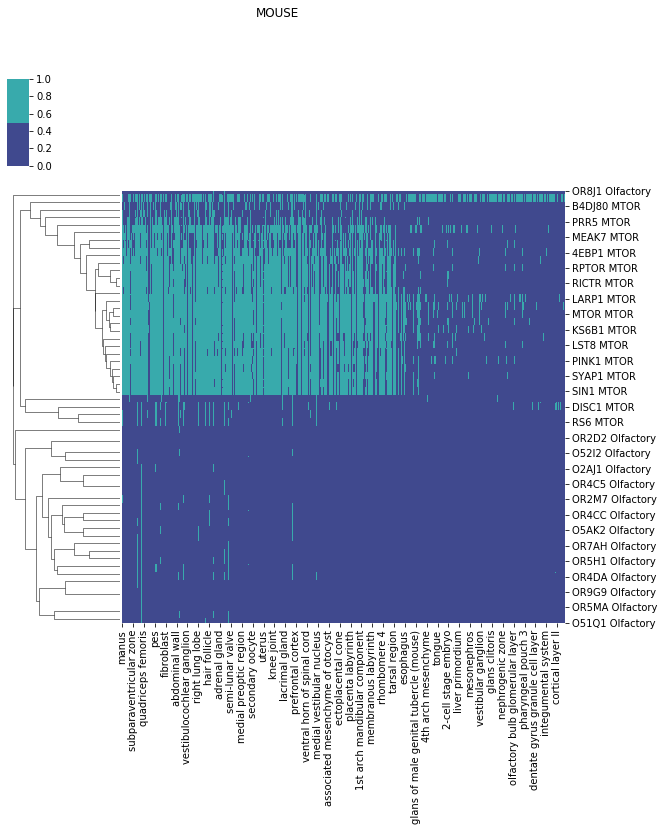

/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


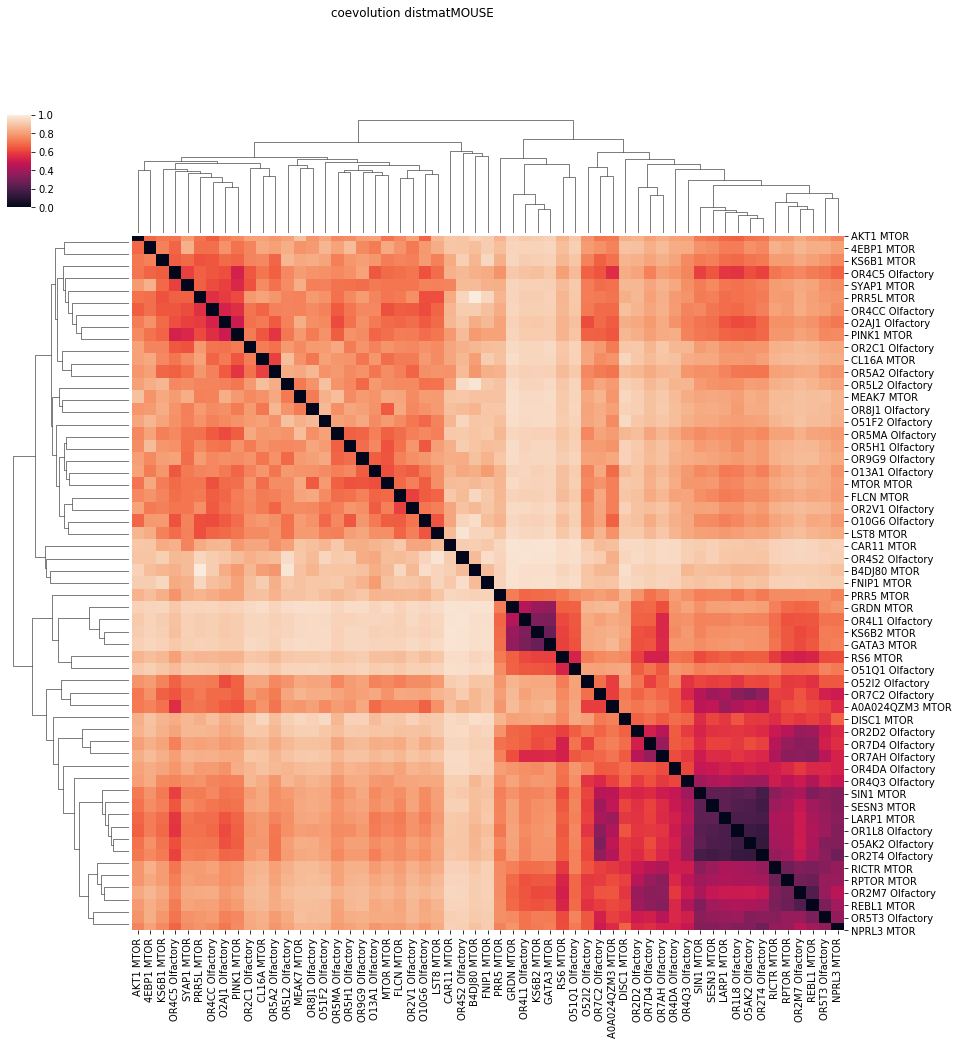

/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


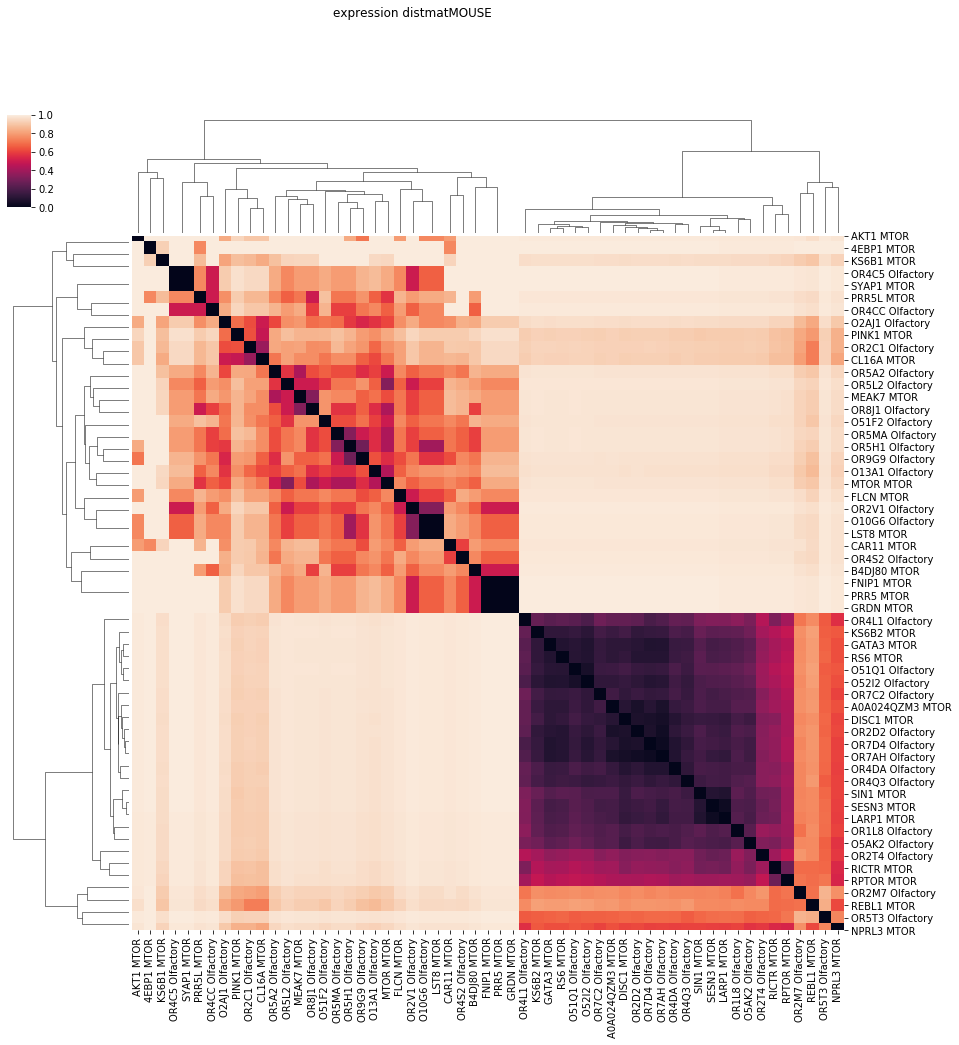

 do our matrices match from one approach to the other? 
Pearson:(0.1829976954804644, 7.308041982293815e-26)
PIGXX
                                                   anat             geneEns  \
anatName                                                                      
liver     http://purl.obolibrary.org/obo/UBERON_0002107  ENSSSCG00000012148   
lung      http://purl.obolibrary.org/obo/UBERON_0002048  ENSSSCG00000007981   
liver     http://purl.obolibrary.org/obo/UBERON_0002107  ENSSSCG00000013292   
heart     http://purl.obolibrary.org/obo/UBERON_0000948  ENSSSCG00000005169   
liver     http://purl.obolibrary.org/obo/UBERON_0002107  ENSSSCG00000021748   

         species canonicalid       names  
anatName                                  
liver      PIGXX  A0A287AX76  SYAP1 MTOR  
lung       PIGXX  A0A4X1UMH2  NPRL3 MTOR  
liver      PIGXX      F1SHG4  PRR5L MTOR  
heart      PIGXX  A0A4X1WBG6    RS6 MTOR  
liver      PIGXX  A0A4X1W4L1   PRR5 MTOR  
            liver  lung  heart 

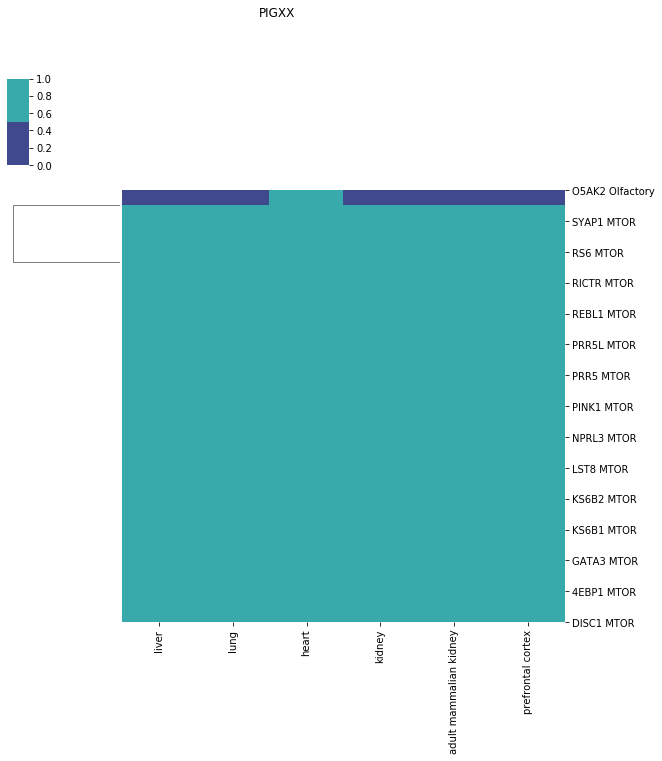

/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


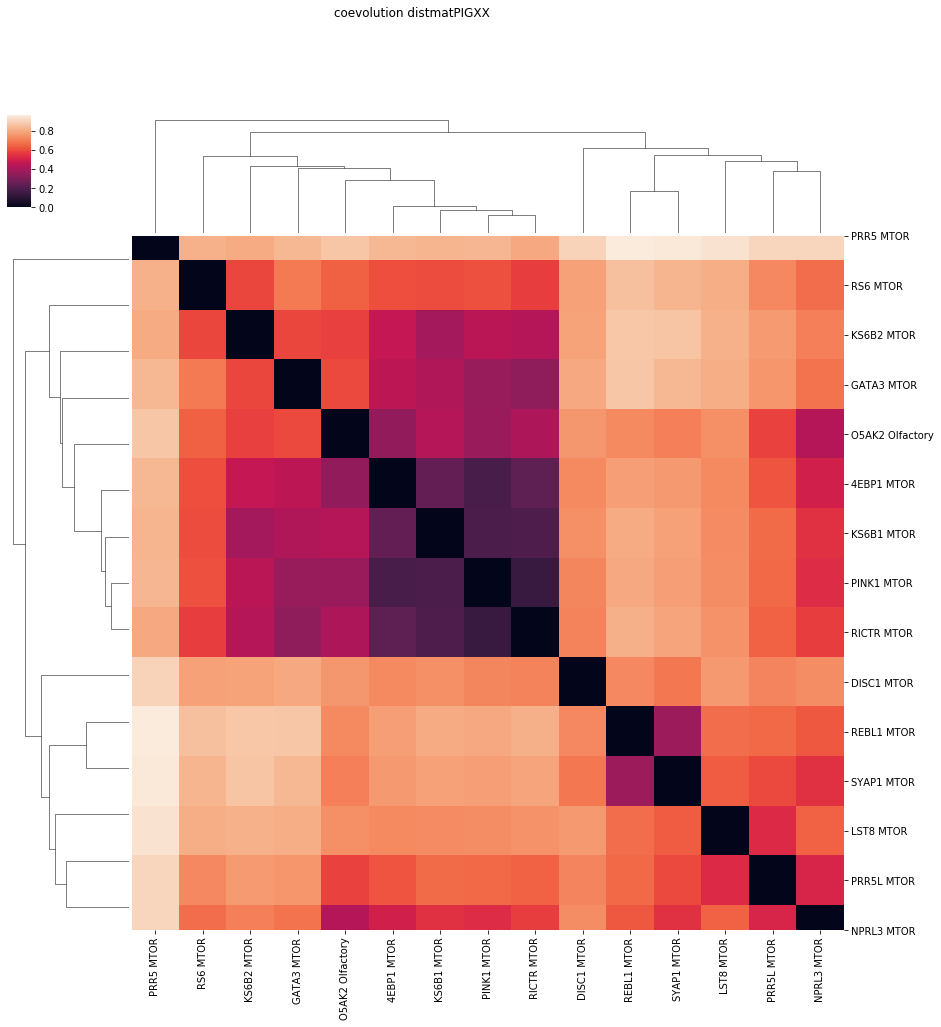

/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


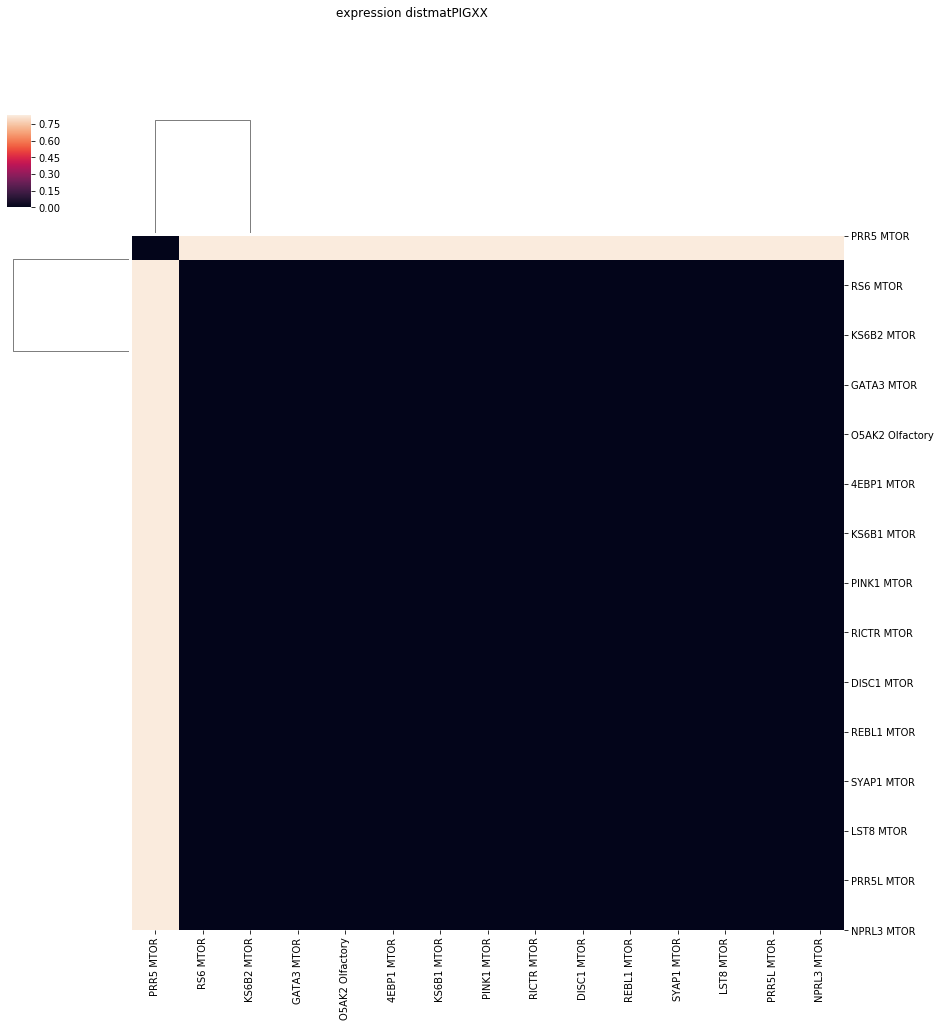

 do our matrices match from one approach to the other? 
Pearson:(-0.11033459048411869, 0.0987702741518936)
FELCA
                                                                 anat  \
anatName                                                                
adult mammalian kidney  http://purl.obolibrary.org/obo/UBERON_0000082   
prefrontal cortex       http://purl.obolibrary.org/obo/UBERON_0000451   
liver                   http://purl.obolibrary.org/obo/UBERON_0002107   
adult mammalian kidney  http://purl.obolibrary.org/obo/UBERON_0000082   
prefrontal cortex       http://purl.obolibrary.org/obo/UBERON_0000451   

                                   geneEns species canonicalid       names  
anatName                                                                    
adult mammalian kidney  ENSFCAG00000029143   FELCA      M3X836   SIN1 MTOR  
prefrontal cortex       ENSFCAG00000028983   FELCA  A0A2I2UIE8  PRR5L MTOR  
liver                   ENSFCAG00000003395   FELCA      M3W099  KS6

/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:682: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)


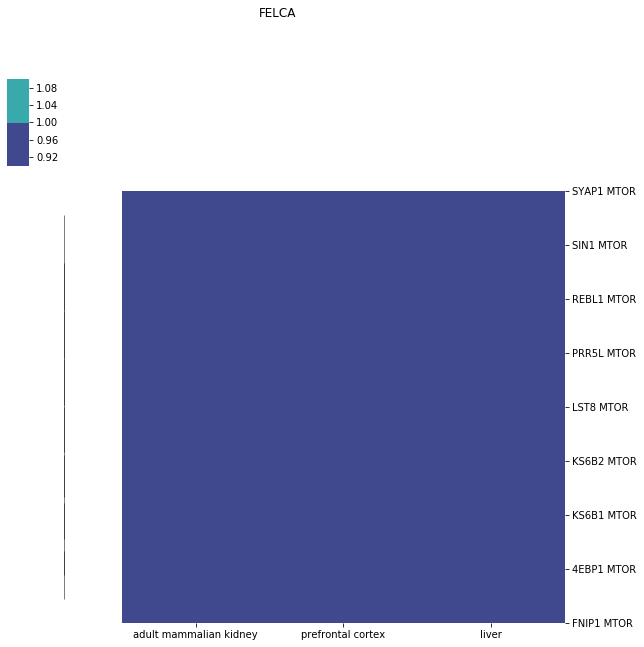

/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


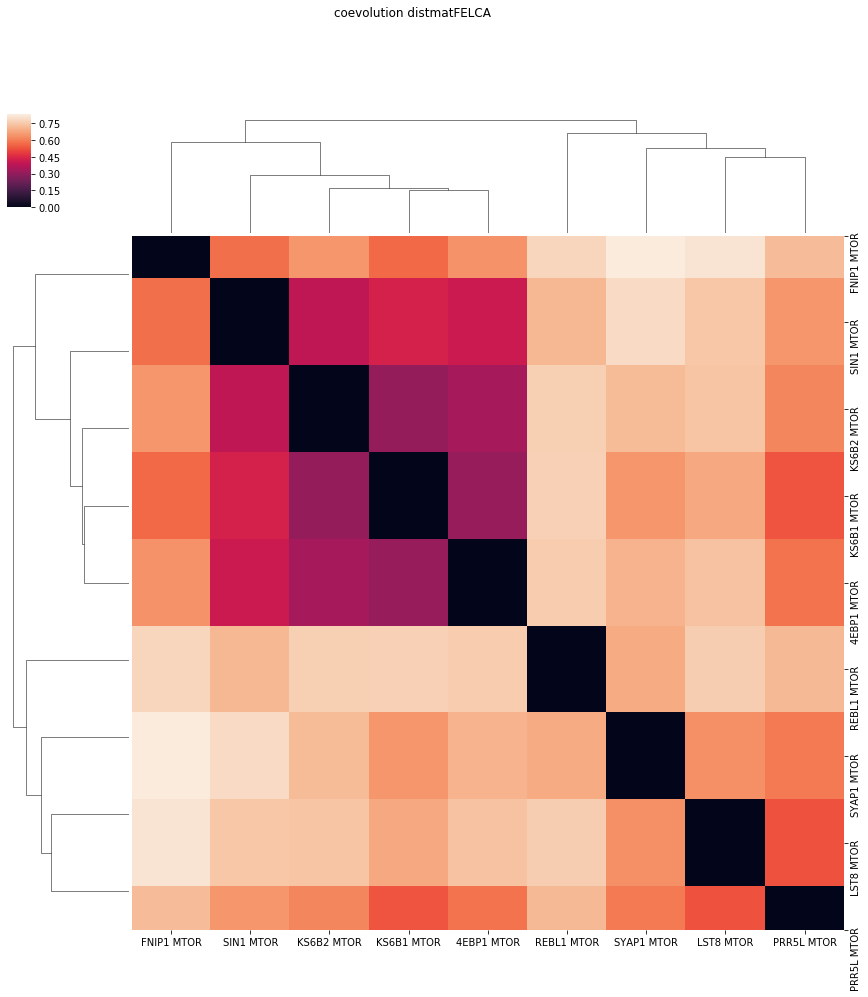

/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:682: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)
/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/cactuskid/.local/lib/python3.7/site-packages/seaborn/matrix.py:690: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


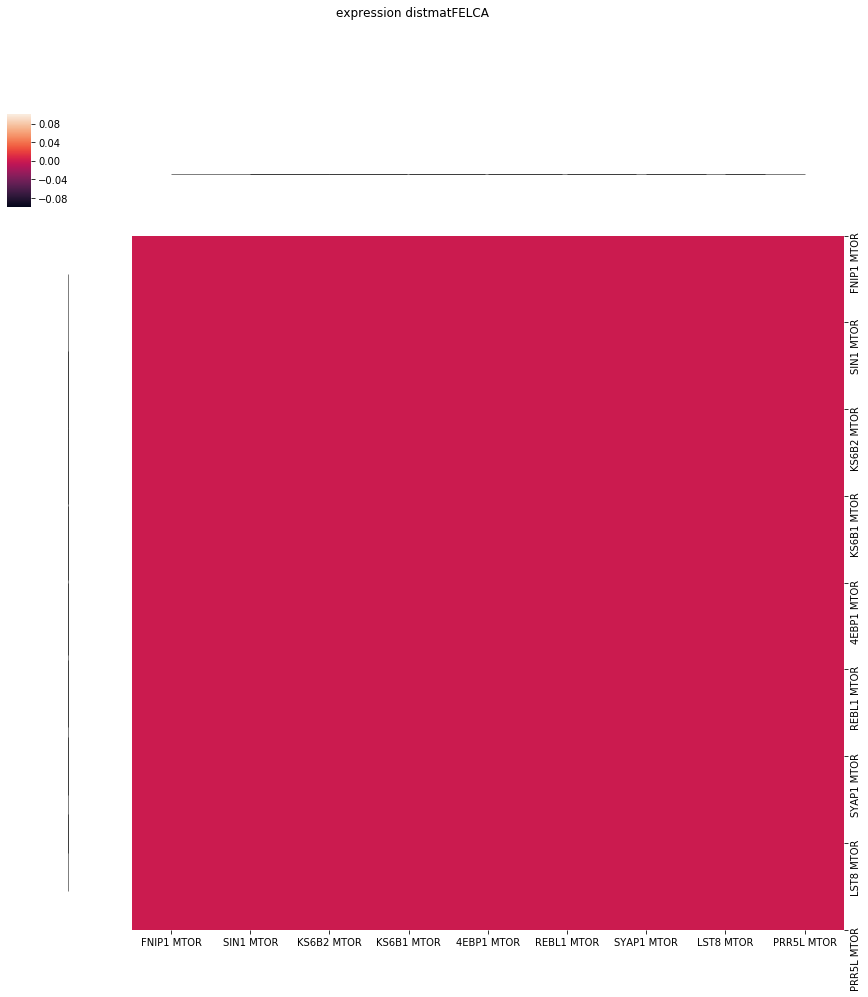

 do our matrices match from one approach to the other? 
Pearson:(nan, nan)


In [30]:
#now for the results of our efforts!
#let's see if the expression data shows the same pattern as our evolutionary profile comparison

#we can also try to see if the match between our distance matrices is significant between approaches
#the most informative comparison is to check between evolutionary and expression based distances
#If they are significantly similar we can be fairly certain there's an underlying 
#biological network driving this signal

from scipy.stats import pearsonr , spearmanr
for spec in expressionDF.species.unique():
    selected = set()
    #lets look at the clustering of the expression data for each species
    print(spec)
    sub = expressionDF[expressionDF.species == spec]
    #we can create another dataframe which shows the genes expressed in each tissue
    print(sub.head())
    #each row is a gene
    #each column is a tissue
    
    #we only consider tissues where at least one of the genes is expressed
    rows = list(sub.names.unique())
    columns = list(sub.index.unique())
    expr_mat = {r :{ c : 0 for c in columns  } for r in rows }
    
    #lets set all of the places where each gene is expressed to 1
    for i,r in sub.iterrows():
        selected.add(r.names)
        expr_mat[r.names][i] = 1
    
    #and transform everything into a dataframe
    expr_mat = pd.DataFrame.from_dict( expr_mat, orient='index')
    
    print(expr_mat.head())
    print(selected)
    
    #and use seaborn again to generate a clustered heatmap figure
    #to show similarity in expression patterns across tissues
    
    g = sns.clustermap(expr_mat , metric= metrics[2] , method=methods[1] , col_cluster=False, row_cluster= True , cmap = sns.color_palette("mako", 2))
    g.fig.suptitle(spec)
    g.savefig( spec+'expcluster.svg')
    plt.show()
    
    sub_orthodf = orthosdf.loc[selected]

    
    distmat_ortho = cdist(sub_orthodf.to_numpy(), sub_orthodf.to_numpy() , metric = metrics[2])
    g = sns.clustermap( distmat_ortho , metric= metrics[0] , method=methods[1] , col_cluster=True, row_cluster= True, yticklabels = selected , xticklabels = selected , figsize = (15, 15)  )
    g.fig.suptitle( 'coevolution distmat' + spec) 
    plt.show()
    
    
    distmat_expr = cdist(expr_mat.to_numpy(), expr_mat.to_numpy() , metric = metrics[2])
    g = sns.clustermap( distmat_expr , metric= metrics[0] , method=methods[1] , col_cluster=True, row_cluster= True, yticklabels = selected, xticklabels =selected , figsize = (15, 15) )
    g.fig.suptitle( 'expression distmat' + spec ) 

    plt.show()
    
    print( ' do our matrices match from one approach to the other? ')
    print( 'Pearson:'+ str( pearsonr( distmat_ortho.ravel() , distmat_expr.ravel() )  ) ) 
    